<a href="https://colab.research.google.com/github/kanishkkg/ampba_24_group18_term2/blob/main/ml_ul/GR_18_MLUL1_group18_Products.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter notebook submission created by Group 18
* Kanishk Kumar Gupta - 12310008

## Part (2/2) - Product Clustering and Segementation

### Installing relevant libraries

In [32]:
import pandas as pd
import numpy as np
import string

!pip install scikit-learn --upgrade
from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [33]:
url = 'https://raw.githubusercontent.com/kanishkkg/ampba_24_group18_term2/main/ml_ul/Champo%20Carpets%20V1.csv'

In [34]:
base_data = pd.read_csv(url)

In [35]:
base_data.head()

,OrderiD,Item_Id,CustomerCode,CountryName,customer_country,QtyRequired,TotalArea,Amount,ITEM_NAME,QualityName,DesignName,ColorName,ShapeName
0,1,5,H-1,USA,H-1USA,6,128.25,769.5,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],GREEN/IVORY,REC
1,1,26,H-1,USA,H-1USA,6,117.00,702.0,HAND TUFTED,TUFTED 60C,DUDLEY [9012],BEIGE,REC
2,1,17,H-1,USA,H-1USA,7,88.00,616.0,HAND TUFTED,TUFTED 60C,WEMBLY [CC-206],BEIGE/SAGE,REC
3,1,496,H-1,USA,H-1USA,7,88.00,616.0,HAND TUFTED,TUFTED 60C,SYMPHONY [8900],CHARCOAL,REC
4,1,30,H-1,USA,H-1USA,5,117.00,585.0,HAND TUFTED,TUFTED 60C,DUDLEY [9012],NAVY/BEIGE,REC


In [36]:
base_data.drop_duplicates(inplace=True)

### Product Segmentation

In [37]:
item_data = base_data.copy(deep=True)

In [38]:
# Checking if each item as a unique shape or not
agg_data = item_data.groupby('Item_Id').agg(
    unique_shapes=('ShapeName', 'nunique')
).reset_index()
agg_data[agg_data['unique_shapes'] != 1]

,Item_Id,unique_shapes


In [47]:
len(item_data['ShapeName'].value_counts())

5

In [51]:
item_data['price'] = item_data['Amount']/item_data['QtyRequired']

item_data[['Item_Id', 'price']]

agg_data = item_data.groupby('Item_Id').agg(
    min_price=('price', 'min'),
    max_price=('price', 'max'),
).reset_index()

agg_data[agg_data['min_price'] != agg_data['max_price']]

,Item_Id,min_price,max_price
10,11,71.25,195.93000
48,52,0.00,165.60000
49,55,80.00,160.00000
52,58,0.00,160.00000
56,64,80.00,160.00000
...,...,...,...
5809,45871,6.75,6.91875
5811,45873,6.75,6.91875
5814,45880,6.75,6.91875
5816,45882,6.75,6.91875


In [39]:
item_agg_data = item_data.groupby('Item_Id').agg(
    total_quantity=('QtyRequired','sum'),
    total_revenue=("Amount", "sum"),
    num_of_customers=("customer_country", "nunique"),
    average_quantity=("QtyRequired", 'mean'),
    total_area=("TotalArea", "sum"),
    average_area=("TotalArea", "mean")
).reset_index()

item_agg_data

,Item_Id,total_quantity,total_revenue,num_of_customers,average_quantity,total_area,average_area
0,1,2,12.00,1,2.0,6.0,6.00
1,2,2,18.00,1,2.0,9.0,9.00
2,3,7,378.00,1,3.5,108.0,54.00
3,4,9,641.25,1,4.5,142.5,71.25
4,5,22,2821.50,1,11.0,256.5,128.25
...,...,...,...,...,...,...,...
5870,46697,28,663.60,1,28.0,6.0,6.00
5871,46698,10,888.70,1,10.0,22.5,22.50
5872,46699,15,4740.00,1,15.0,80.0,80.00
5873,46700,7,2986.20,1,7.0,108.0,108.00


In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(item_agg_data[['total_quantity', 'total_revenue', 'num_of_customers',
                                                      'average_quantity', 'total_area', 'average_area']])

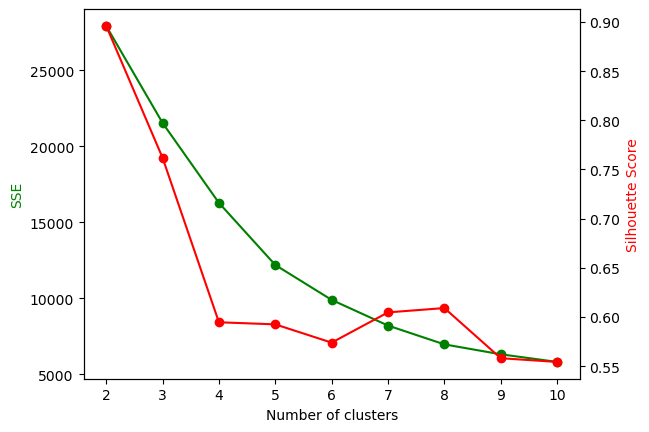

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming 'scaled_features' is the scaled version of item_agg_data

sse = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plotting the Elbow Method and Silhouette Scores
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(2, 11), sse, 'go-')
ax2.plot(range(2, 11), silhouette_scores, 'ro-')

ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('SSE', color='g')
ax2.set_ylabel('Silhouette Score', color='r')

plt.show()


In [42]:
from sklearn.cluster import KMeans

# Determine the number of clusters (this can be fine-tuned)
n_clusters = 8  # Example number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(scaled_features)

# Adding cluster labels to the original data
item_agg_data['Cluster'] = clusters


In [43]:
# Analyzing each cluster
for i in range(n_clusters):
    cluster_data = item_agg_data[item_agg_data['Cluster'] == i]
    print(f"\nCluster {i}:")
    print(cluster_data.describe())



Cluster 0:
            Item_Id  total_quantity  total_revenue  num_of_customers  \
count    143.000000      143.000000     143.000000             143.0   
mean    6726.636364       69.818182   21502.954965               1.0   
std     7820.135098       97.194566   26289.072243               0.0   
min       80.000000        1.000000     210.000000               1.0   
25%     1451.000000       15.000000    5663.000000               1.0   
50%     3313.000000       36.000000   11221.200000               1.0   
75%    11215.000000       75.500000   25802.000000               1.0   
max    31370.000000      709.000000  163347.040000               1.0   

       average_quantity   total_area  average_area  Cluster  
count        143.000000   143.000000    143.000000    143.0  
mean           6.704921  1077.713566    147.030457      0.0  
std            6.923385   385.063081    113.451246      0.0  
min            1.000000   450.000000     37.400000      0.0  
25%            2.519231   756

In [44]:
hdbscan = HDBSCAN(min_cluster_size=2, cluster_selection_epsilon=1)
customer_agg_data['hdbscan_cluster'] = hdbscan.fit_predict(scaled_features)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=customer_agg_data['hdbscan_cluster'], cmap='viridis', marker='o')
plt.title("Customer Segments (HDBSCAN Clustering)")
plt.xlabel("Scaled Frequency")
plt.ylabel("Scaled Monetary Value")
plt.show()


# Checking the count of customers in each cluster
cluster_counts = customer_agg_data['hdbscan_cluster'].value_counts().sort_index()

# Descriptive statistics for each cluster
cluster_description = customer_agg_data.groupby('hdbscan_cluster').agg({
    'frequency': ['mean', 'median', 'min', 'max'],
    'monetary_value': ['mean', 'median', 'min', 'max']
})

cluster_counts, cluster_description.round(2)

NameError: ignored

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Applying PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

# Extracting the two principal components for visualization
pc1 = reduced_data[:, 0]
pc2 = reduced_data[:, 1]

pca.explained_variance_ratio_

In [ ]:
# Assuming 'clusters' contains the cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(pc1, pc2, c=clusters, cmap='viridis', marker='o', edgecolor='k', s=70, alpha=0.7)
plt.title('Cluster Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()